# Objective: Given a Gold nanocube, obtain its wavelength (energy) scans 10 times consecutively via AOTF-VIS. Following this:

### 1. Plot the 10 consecutive scans on a single graph, taking wavelength (nm) in the x-axis and corrected extinction (a.u) in the y-axis.

### 2. Extract the regions in all the scans where a local peak is observed. Plot them together in the same manner as above, using energy (eV) in the x-axis instead.

### 3. Obtain the best-fit Lorentzian curve for all the scans. Extract the respective Full Width at Half Maximum (FWHM) and peak Resonant Energy ($E_{res}$) for all of the scans. Plot all the best-fits together.

### 4. Plot all the best-fits together but ensure that the curves are normalised w.r.t. peak corrected extinction.

### 5. Obtain $\Delta$FWHM i.e. the FWHM of all scans relative to that of the 1$^{st}$ scan. Plot these values w.r.t. $E_{res}$.

### 6. Obtain $\Delta E_{res}$ i.e. the peak Resonant Energy of all the scans relative to that of the 1$^{st}$ scan. Plot these values w.r.t. $E_{res}$.

### 7. Single-scan mode: Obtain the FWHM and $E_{res}$ for a single scan dataset that will act as a reliability check for the entire cube.

## Relevant packages and modules required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
import os
from pylab import cm
from lmfit.models import LorentzianModel
from tabulate import tabulate

## Function to extract our parameters of interest as well as the number of repeats for the respective scans from the data files

In [2]:
def parameter_formatting_WL(filename, r_skip=84, n_rows=3, loc=2):
    user_col = ["Wavelength(nm)", "FocusCorrectionY[µm]", "Repeat(x)", "M(V)", "Phase(')", "IS(A)", "Phase(').1", "R(V)", "Phase(').2"]
    readfile = pd.read_csv(filename, delim_whitespace=1, skiprows=r_skip, names=user_col)
    stepsfile = pd.read_csv(filename, sep='\t', skiprows=9, nrows=n_rows)
    repeats_WL = int(stepsfile.iloc[loc]['Loops:'][-8:-6])
    repeats_M = 1
    if n_rows == 4:
        repeats_M=int(stepsfile.iloc[0]['Loops:'][-9:-6])
    repeats=[repeats_WL, repeats_M]
    return readfile, repeats

## Function to generate extinction arrays for the given csv file

In [3]:
def extinction(readfile, repeats):
    extinctions = readfile.loc[:,"R(V)"]/readfile.loc[:,"M(V)"]
    extinctions = extinctions.groupby(np.arange(len(extinctions))//repeats[0]).mean()
    return extinctions

## Function to store extinction data for the consecutive scans as a 2D array i.e. Scan 1 data will be in column 1, Scan 2 in column 2, and so on

In [4]:
def ext_matrix(extinctions, repeats):
    n_rows = len(extinctions)//repeats[1]
    n_cols = repeats[1]
    extin_matrix=np.zeros((n_rows, n_cols))
    for i in range(n_cols):
        loc = n_rows*i
        extin_matrix[:,i] = extinctions[loc:(loc+n_rows)]
    return extin_matrix

## Function that finds the corrected extinctions for all the scans by utilising the reference data

In [5]:
def corr_ext(extin_matrix, extin_ref):
    n_rows, n_cols = extin_matrix.shape
    corr_extin_matrix = np.zeros((n_rows, n_cols))
    for i in range(n_cols):
        corr_extin_matrix[:,i] = 1.00 - (extin_matrix[:,i]/extin_ref)
    return corr_extin_matrix

## Function that prepares the extinction 2D array as well as the wavelengths for subsequent plotting as per Objective 1

In [6]:
def data_prep_ob1(wavelengths, corr_extin_matrix):
    n_rows, n_cols = corr_extin_matrix.shape
    xData = np.zeros((n_cols, n_rows))
    yData = np.zeros((n_cols, n_rows))
    for i in range(n_cols):
        xData[i,:] = wavelengths
        yData[i,:] = corr_extin_matrix[:,i]
    return xData, yData

## Function that yields the plot as per Objective 1 and 2

In [7]:
def plot_ob1_2(xData = [], yData = [], xLabel = '', yLabel = 'Extinction (a.u.)', Title = '', f = ''):
    n_rows, n_cols = yData.shape
    colors = cm.get_cmap('viridis', n_rows)
    plt.figure(num = None, figsize = (10, 7), facecolor = 'w', edgecolor = 'k')
    for i in range(n_rows):
        plt.plot(xData[i,:], yData[i,:], label = "Scan "+str(i+1), color = colors(i))
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(loc='upper right')
        plt.title(Title)
        plt.legend(bbox_to_anchor=(0.99, 0.99),  borderaxespad=0)
    plt.show
    plt.savefig(f)

## Function that converts the wavelength (in nm) to energy (in eV)

In [8]:
def lambda_to_E(wavelengths):
    return (sc.h*sc.c*10**9/sc.e)/(wavelengths)

## Function that yields the wavelength slice of the expected peak as well as the corresponding extinction data slice

In [9]:
def data_slice(xData, yData, left_thres = 650.0, right_thres = 755.0):
    n_rows, n_cols = yData.shape
    xSlice = np.zeros((n_rows, n_cols))
    ySlice = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        begin_index = np.nonzero(xData[i,:] == left_thres)[0][0]
        end_index = np.nonzero(xData[i,:] == right_thres)[0][0]
        fit_range = slice(begin_index, end_index+1)
        xSlice[i,fit_range] = xData[i,fit_range]
        ySlice[i,fit_range] = yData[i,fit_range]
    return xSlice[:, ~np.all(xSlice == 0, axis = 0)], ySlice[:, ~np.all(ySlice == 0, axis = 0)]

## Function that obtains the best-fit Lorentzian curves for the consecutive data slices provided

In [10]:
def lorentzian_fit(xSlice, ySlice):
    n_rows, n_cols = ySlice.shape
    model = LorentzianModel()
    result_params = []
    result_bestfit = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        params = model.guess(ySlice[i,:], xSlice[i,:])
        results = model.fit(ySlice[i,:], params, x=xSlice[i,:])
        result_params.append(list(results.params.items()))
        result_bestfit[i,:] = results.best_fit
    return result_params, result_bestfit

## Function that extracts the model best-fit parameters held in a dictionary and stores it in a 2D array

In [11]:
def param_dict_array(params):
    n_rows = len(params)
    no_of_params = len(params[0])
    param_set = np.zeros((n_rows, no_of_params))
    for i in range(n_rows):
        for j in range(no_of_params):
            param_set[i,j] = params[i][j][1].value
    return param_set

## Function that extracts the FWHM, $E_{res}$, and height of peak maxima for the 10 consecutive scans

In [12]:
def param_extract(param_set):
    E_res = param_set[:,1]
    fwhm = param_set[:,3]
    height_max_peak = param_set[:,4]
    return fwhm, E_res, height_max_peak

## Function that tabulates the FWHM, $\Delta$FWHM, $E_{res}$, $\Delta E_{res}$, and Height of peak maxima for the 10 consecutive scans

In [13]:
def param_table(fwhm, delta_fwhm, E_res, delta_E_res, h_max, f):
    num_el = len(fwhm)
    table = [['Scan no.', 'FWHM (eV)', 'ΔFWHM (meV)', 'E_res (eV)', 'ΔE_res (meV)', 'Height of peak maxima (a.u.)']]
    for i in range(num_el):
        row = ['Scan '+str(i+1), fwhm[i], delta_fwhm[i]*1000, E_res[i], delta_E_res[i]*1000, h_max[i]]
        table.append(row)
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', floatfmt=".4f"))
    table_df=pd.DataFrame(table)
    table_df.to_csv(f, index=False, header=False)

## Function that normalizes the extinction dataset as well as the best-fit extinction dataset w.r.t. height of peak maxima for the 10 consecutive scans as per Objective 4

In [14]:
def extinction_normalize(yData, yFit, h_max):
    n_rows, n_cols = yData.shape
    yData_norm = np.zeros((n_rows, n_cols))
    yFit_norm = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        yData_norm[i,:] = yData[i,:]/h_max[i]
        yFit_norm[i,:] = yFit[i,:]/h_max[i]
    return yData_norm, yFit_norm

## Function that plots the best-fit Lorentzian curves along with the corresponding datasets (as dots) for the 10 consecutive scans as per Objective 3 and 4

In [15]:
def plot_ob3_4(xData = [], yData = [], yFit = [], xLabel = '', yLabel = 'Extinction (a.u.)', Title = '', f = ''):
    n_rows, n_cols = yData.shape
    colors = cm.get_cmap('viridis', n_rows)
    plt.figure(num = None, figsize = (10, 7), facecolor = 'w', edgecolor = 'k')
    for i in range(n_rows):
        plt.plot(xData[i,:], yFit[i,:], '-', label = "Scan "+str(i+1), color = colors(i))
        plt.plot(xData[i,:], yData[i,:], '.', color = colors(i))
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(loc='upper right')
        plt.title(Title)
        plt.legend(bbox_to_anchor=(0.99, 0.99),  borderaxespad=0)
    plt.show
    plt.savefig(f)

## Function that finds $\Delta$FWHM and $\Delta E_{res}$ as per Objective 5 and 6

In [16]:
def delta_param(fwhm, E_res):
    n_rows = len(fwhm)
    delta_fwhm = []
    delta_E_res = []
    for i in range(n_rows):
        delta_fwhm.append((fwhm[i] - fwhm[0]))
        delta_E_res.append((E_res[i] - E_res[0]))
    return delta_fwhm, delta_E_res

## Function that plots $\Delta$FWHM (meV) and $\Delta E_{res}$ (meV) versus $E_{res}$ (eV) for the 10 consecutive scans as per Objective 5 and 6

In [17]:
def plot_ob5_6(xData = [], yData = [], xLabel = '', yLabel = '', Title = '', f = '', loci = 'best'):
    n_rows = len(yData)
    colors = cm.get_cmap('viridis', n_rows)
    plt.figure(num = None, figsize = (10, 7), facecolor = 'w', edgecolor = 'k')
    for i in range(n_rows):
        plt.plot(xData[i], yData[i]*1000, '.', label = "Scan "+str(i+1), color = colors(i))
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(loc=loci)
        plt.title(Title)
        #plt.legend(bbox_to_anchor=(0.99, 0.99),  borderaxespad=0)
    plt.show
    plt.savefig(f)

## Function that tabulates the $\Delta$FWHM (meV) and $\Delta E_{res}$ (meV) for the 10th scan

In [18]:
def scan10_table(delta_fwhm, delta_E_res, f):
    table = [['ΔFWHM_cube (meV)', 'ΔE_res_cube (meV)'], [delta_fwhm[-1]*1000, delta_E_res[-1]*1000]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', floatfmt=".4f"))
    table_df=pd.DataFrame(table)
    table_df.to_csv(f, index=False, header=False)

## Function that tabulates the FWHM and $E_{res}$ for single scan mode as per Objective 7

In [19]:
def scan1_table(fwhm, E_res, f):
    table = [['FWHM (eV)', 'E_res (eV)'], [fwhm[0], E_res[0]]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', floatfmt=".4f"))
    table_df=pd.DataFrame(table)
    table_df.to_csv(f, index=False, header=False)

## Function where the protocol is executed for all objectives

In [20]:
def Nanocube_Lorentzian(mode, f1, f2, title_list, export_list):
    
    cwd = os.getcwd()
    csv_dir = '/csv/'
    fig_dir = '/Figures/'
    
    if mode == 1:
        hits, repeats1 = parameter_formatting_WL(cwd + csv_dir + f1, 84, 3, 2)
    else:
        hits, repeats1 = parameter_formatting_WL(cwd + csv_dir + f1, 86, 4, 3)
        
    miss, repeats2 = parameter_formatting_WL(cwd + csv_dir + f2, 84, 3, 2)
    
    hits_ext = extinction(hits, repeats1)
    miss_ext = extinction(miss, repeats2)
    
    hits_ext_matrix = ext_matrix(hits_ext, repeats1)
    
    corr_hits_ext_matrix = corr_ext(hits_ext_matrix, miss_ext)
    
    wavelengths = miss.loc[::repeats2[0],'Wavelength(nm)'].values
    
    xdata, ydata = data_prep_ob1(wavelengths, corr_hits_ext_matrix)
    
    plot_ob1_2(xdata, ydata, 'Wavelength (nm)', 'Extinction (a.u.)', title_list[0], cwd + fig_dir + export_list[0])
    
    xslice1, yslice = data_slice(xdata, ydata)
    xslice = lambda_to_E(xslice1)
    
    plot_ob1_2(xslice, yslice, 'Energy (eV)', 'Extinction (a.u.)', title_list[1], cwd + fig_dir + export_list[1])
    
    fit_params, fit_ydata = lorentzian_fit(xslice, yslice)
    fit_param_set = param_dict_array(fit_params)
    
    FWHM, E_res, height_max_peak = param_extract(fit_param_set)
    
    plot_ob3_4(xslice, yslice, fit_ydata, 'Energy (eV)', 'Extinction (a.u.)', title_list[2], cwd + fig_dir + export_list[2])
    plot_ob1_2(xslice, fit_ydata, 'Energy (eV)', 'Extinction (a.u.)', title_list[3], cwd + fig_dir + export_list[3])
    
    yslice_norm, fit_ydata_norm = extinction_normalize(yslice, fit_ydata, height_max_peak)
    
    plot_ob3_4(xslice, yslice_norm, fit_ydata_norm, 'Energy (eV)', 'Extinction (a.u.)', title_list[4], cwd + fig_dir + export_list[4])
    plot_ob1_2(xslice, fit_ydata_norm, 'Energy (eV)', 'Extinction (a.u.)', title_list[5], cwd + fig_dir + export_list[5])
    
    if mode == 1:
        scan1_table(FWHM, E_res, cwd + csv_dir + export_list[6])
    else:
        delta_FWHM, delta_E_res = delta_param(FWHM, E_res)
    
        plot_ob5_6(E_res, delta_FWHM, 'E_res (eV)', 'ΔFWHM (meV)', title_list[6], cwd + fig_dir + export_list[6])
        plot_ob5_6(E_res, delta_E_res, 'E_res (eV)', 'ΔE_res (meV)', title_list[7], cwd + fig_dir + export_list[7], 'lower right')

        param_table(FWHM, delta_FWHM, E_res, delta_E_res, height_max_peak, cwd + csv_dir + export_list[8])
        scan10_table(delta_FWHM, delta_E_res, cwd + csv_dir + export_list[9])

## Main function for Consecutive Scans Mode

In [21]:
def Consecutive_Scans_Mode(f1 = "10ConsScan_cube9.csv", f2 = "10ConsScan_cube9ref.csv"):
    
    title_list = ['','','','','','','','']
    export_list = ['','','','','','','','','','']
    
    title_list[0] = 'Consecutive Wavelength Scans on Nanocube'
    title_list[1] = 'Consecutive Wavelength Scans on Nanocube'
    title_list[2] = 'Best-fit Lorentzian Curves for Consecutive Scans'
    title_list[3] = 'Best-fit Lorentzian Curves for Consecutive Scans'
    title_list[4] = 'Normalized Best-fit Lorentzian Curves for Consecutive Scans'
    title_list[5] = 'Normalized Best-fit Lorentzian Curves for Consecutive Scans'
    title_list[6] = 'Change in FWHM vs E_res'
    title_list[7] = 'Change in E_res vs E_res'
    
    export_list[0] = 'Full_wavelength_scan.png'
    export_list[1] = 'Sliced_energy_scan.png'
    export_list[2] = 'Best-fit_Lorentzian_with_dataset.png'
    export_list[3] = 'Best-fit_Lorentzian.png'
    export_list[4] = 'Best-fit_Lorentzian_with_dataset_normalized.png'
    export_list[5] = 'Best-fit_Lorentzian_normalized.png'
    export_list[6] = 'Delta_FWHM_vs_E-res.png'
    export_list[7] = 'Delta_E-res_vs_E-res.png'
    export_list[8] = 'Parameters_of_interest.csv'
    export_list[9] = 'Cube_parameters.csv'
    
    Nanocube_Lorentzian(2, f1, f2, title_list, export_list)

## Main function for Single Scan mode

In [22]:
def Single_Scan_Mode(f1 = "C5.csv", f2 = "C5_ref.csv"):
    
    title_list = ['','','','','','']
    export_list = ['','','','','','','']
    
    title_list[0] = 'Single Wavelength Scan on Nanocube'
    title_list[1] = 'Single Wavelength Scan on Nanocube'
    title_list[2] = 'Best-fit Lorentzian Curve for Single Scan'
    title_list[3] = 'Best-fit Lorentzian Curve for Single Scan'
    title_list[4] = 'Normalized Best-fit Lorentzian Curve for Single Scan'
    title_list[5] = 'Normalized Best-fit Lorentzian Curve for Single Scan'
    
    export_list[0] = 'Single_wavelength_scan.png'
    export_list[1] = 'Single_Sliced_energy_scan.png'
    export_list[2] = 'Single_Best-fit_Lorentzian_with_dataset.png'
    export_list[3] = 'Single_Best-fit_Lorentzian.png'
    export_list[4] = 'Single_Best-fit_Lorentzian_with_dataset_normalized.png'
    export_list[5] = 'Single_Best-fit_Lorentzian_normalized.png'
    export_list[6] = 'Single_scan_parameters.csv'
    
    Nanocube_Lorentzian(1, f1, f2, title_list, export_list)

## Main function that takes in the Mode type as input:

### 1. Single Scan Mode $\rightarrow$ Enter 1

### 2. Consecutive Scans Mode $\rightarrow$ Enter 2

In [23]:
def main_func(mode):
    if mode == 1:
        Single_Scan_Mode()
    elif mode == 2:
        Consecutive_Scans_Mode()
    else:
        print("Invalid input")

## Just call the main function!

╒═════════════╤══════════════╕
│   FWHM (eV) │   E_res (eV) │
╞═════════════╪══════════════╡
│      0.0991 │       1.6992 │
╘═════════════╧══════════════╛


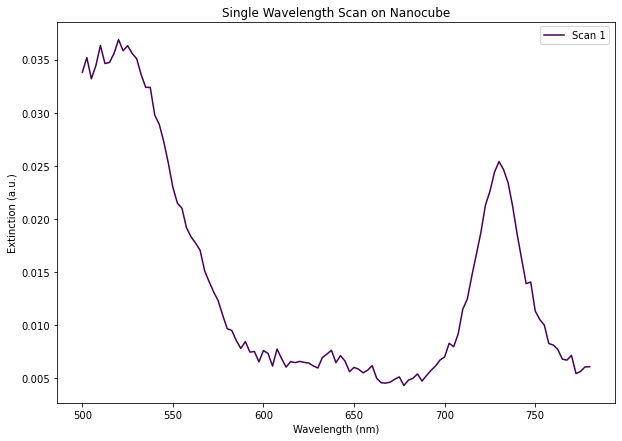

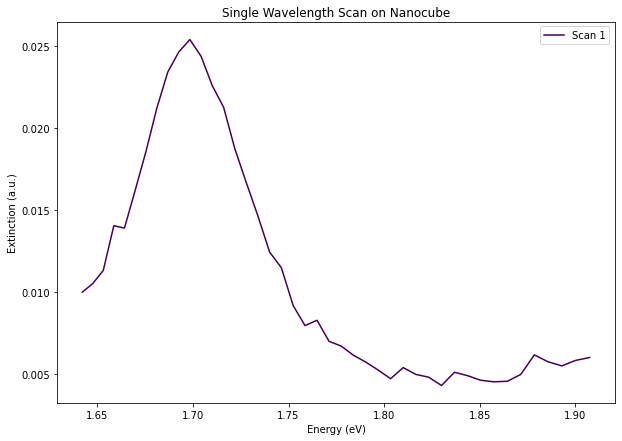

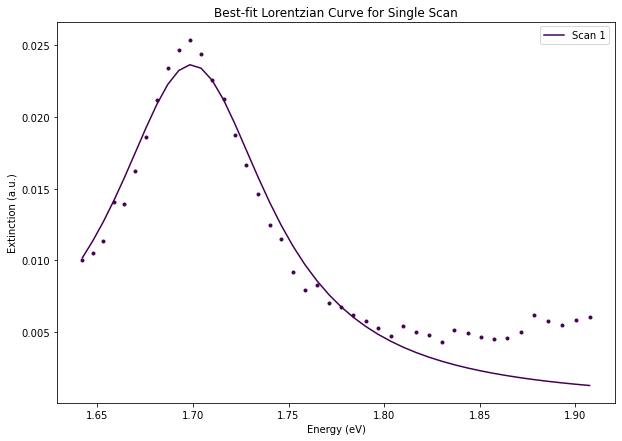

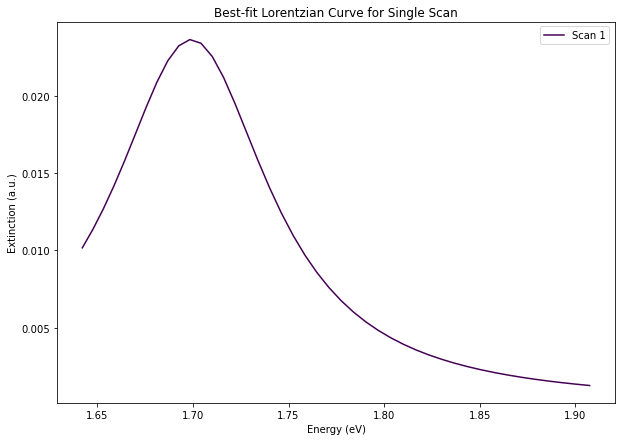

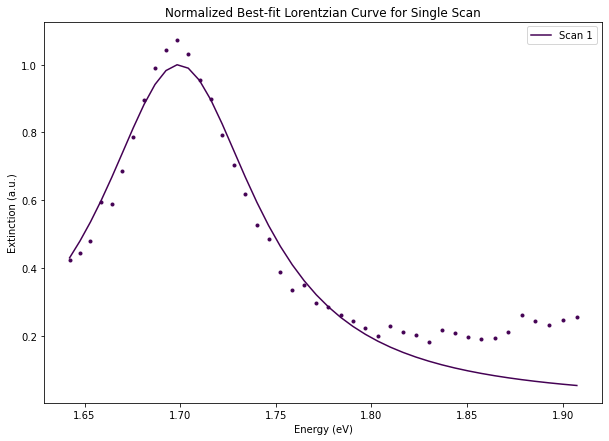

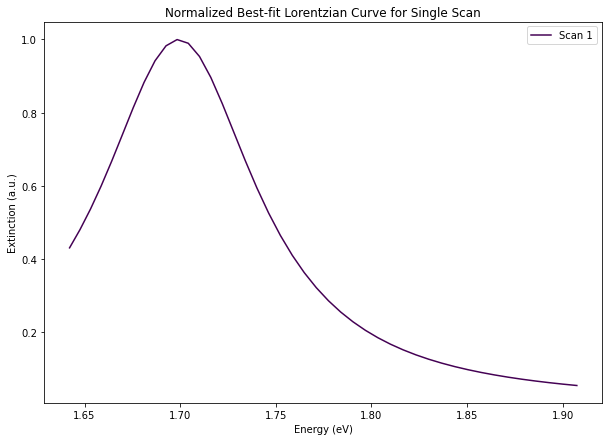

In [24]:
main_func(1)

╒════════════╤═════════════╤═══════════════╤══════════════╤════════════════╤════════════════════════════════╕
│ Scan no.   │   FWHM (eV) │   ΔFWHM (meV) │   E_res (eV) │   ΔE_res (meV) │   Height of peak maxima (a.u.) │
╞════════════╪═════════════╪═══════════════╪══════════════╪════════════════╪════════════════════════════════╡
│ Scan 1     │      0.1299 │        0.0000 │       1.7328 │         0.0000 │                         0.0327 │
├────────────┼─────────────┼───────────────┼──────────────┼────────────────┼────────────────────────────────┤
│ Scan 2     │      0.1724 │       42.4778 │       1.7324 │        -0.3949 │                         0.0241 │
├────────────┼─────────────┼───────────────┼──────────────┼────────────────┼────────────────────────────────┤
│ Scan 3     │      0.1463 │       16.3927 │       1.7387 │         5.9443 │                         0.0338 │
├────────────┼─────────────┼───────────────┼──────────────┼────────────────┼────────────────────────────────┤
│ Scan 4  

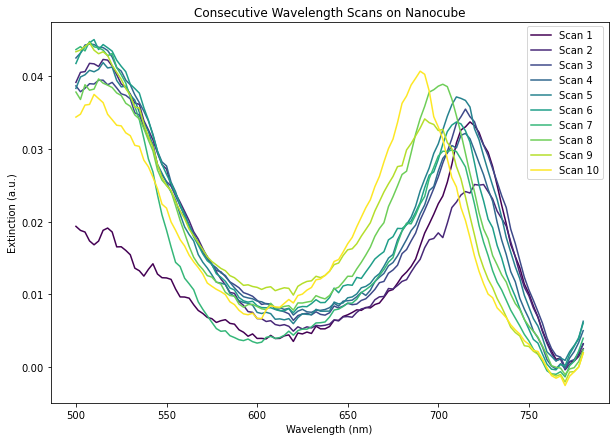

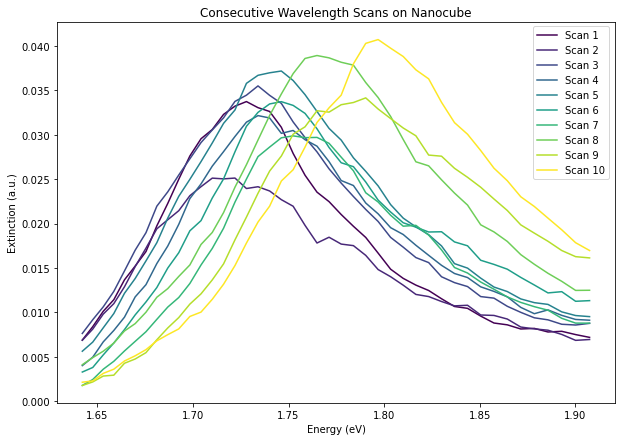

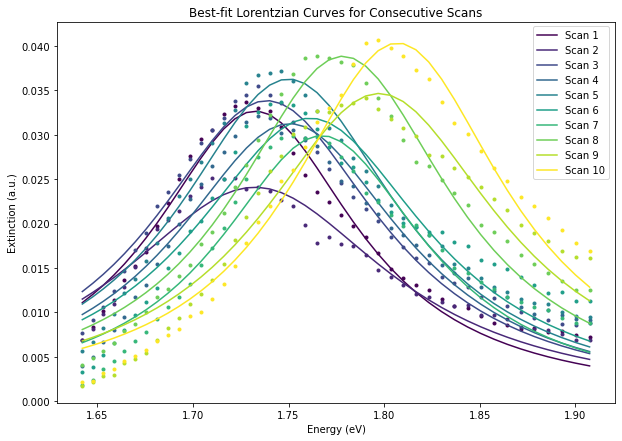

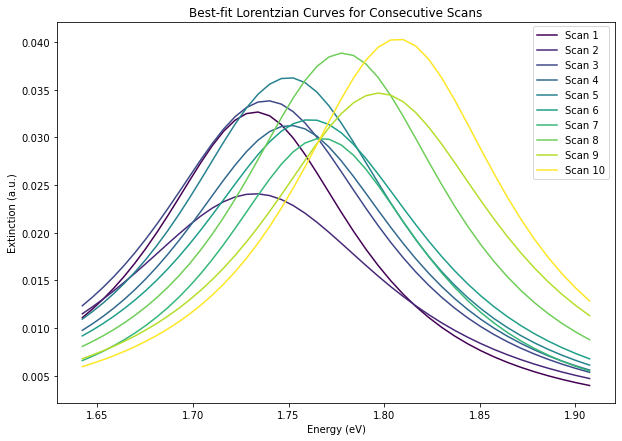

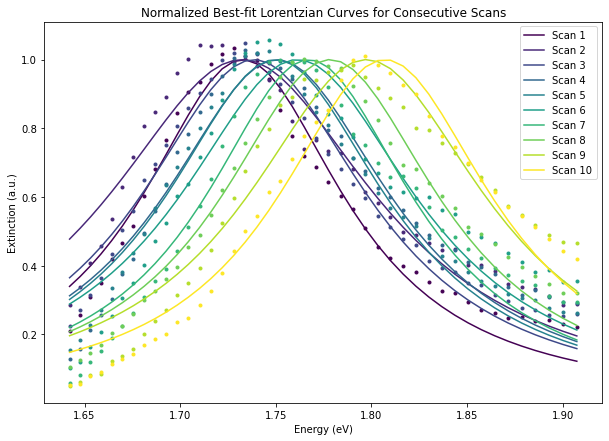

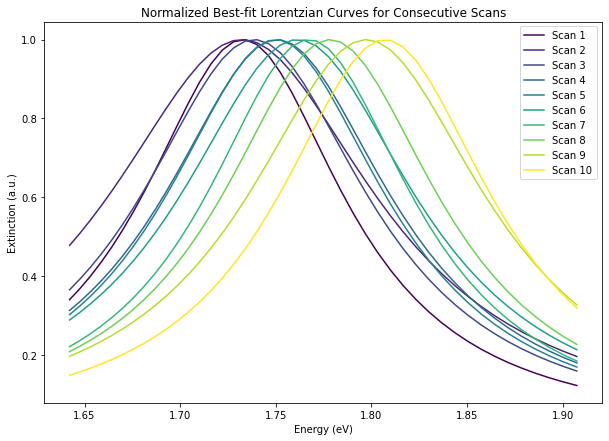

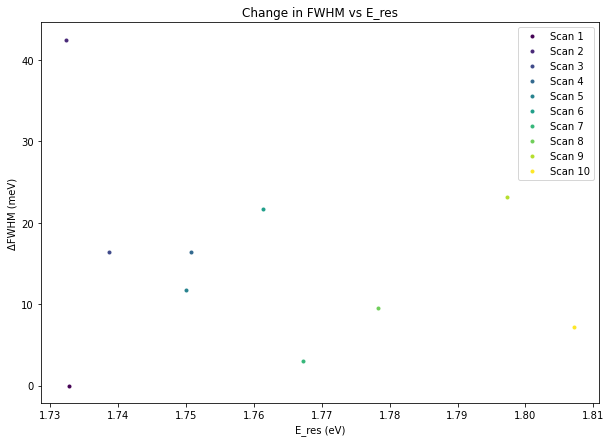

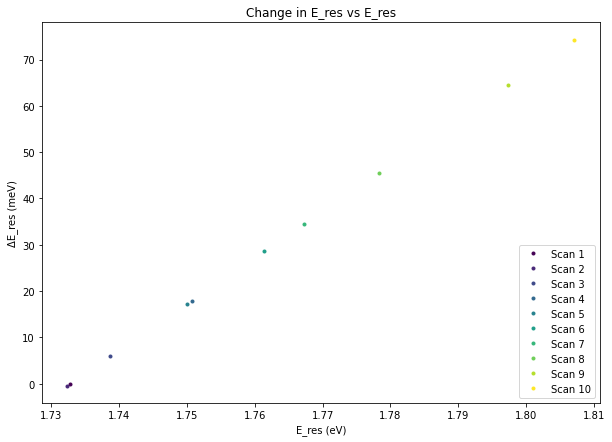

In [25]:
main_func(2)